# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from maze_dataset.tokenization import (
    MazeTokenizer2,
    TokenizerElement,
    CoordTokenizers,
    PromptSequencers,
)

from maze_dataset import (
    VOCAB,
    VOCAB_LIST,
    VOCAB_TOKEN_TO_INDEX,
    LatticeMazeGenerators,
    MazeDataset,
    MazeDatasetConfig,
)

from maze_dataset.plotting import MazePlot

from maze_dataset.util import equal_except_adj_list_sequence

# `MazeTokenizer2` Initialization

Most of the API for these tokenizers is contained in the `MazeTokenizer2` class. The only time when users need to interact with the internal components of a `MazeTokenizer2` is when initializing a non-default tokenizer.

In [45]:
mt_default = MazeTokenizer2()
mt_ctt = MazeTokenizer2(coord_tokenizer=CoordTokenizers.CTT())
# mt_default, mt_ctt

There are 5 internal components of every `MazeTokenizer2`, each of which subclasses `TokenizerElement`. 

In [46]:
print("\n".join([str(elem) for elem in TokenizerElement.__subclasses__()]))
print('\nNo-arg tokenizer defaults:')
print("\n".join([str(elem) for elem in mt_default._tokenizer_elements]))

<class 'maze_dataset.tokenization.maze_tokenizer.CoordTokenizers.CoordTokenizer'>
<class 'maze_dataset.tokenization.maze_tokenizer.AdjListTokenizers._AdjListTokenizer'>
<class 'maze_dataset.tokenization.maze_tokenizer.TargetTokenizers._TargetTokenizer'>
<class 'maze_dataset.tokenization.maze_tokenizer.PathTokenizers._PathTokenizer'>
<class 'maze_dataset.tokenization.maze_tokenizer.PathTokenizers._PromptSequencer'>

No-arg tokenizer defaults:
PromptSequencers.AOTP()
CoordTokenizers.UT()
AdjListTokenizers.Coords(intra=True, post=True, walls=False)
TargetTokenizers.Unlabeled(post=False)
PathTokenizers.Coords(post=False)


Some `TokenizerElement`s also contain their own initialization arguments. Currently, all of these arguments are `boolean`-typed, but more complex args could be added in the future. The most common arguments across all `TokenizerElement`s are `pre`, `intra`, and `post`, which all control the option to add delimiter tokens to that part of the output. Other args are more specialized; see the docstrings for more details.

# Vocabulary

All instances of `MazeTokenizer2` uses a static vocabulary `VOCAB`, which is one of the main functional differences from `MazeTokenizer`. Direct access to the static vocabulary can be made through 3 constants:
- `VOCAB`: extension of the existing `SPECIAL_TOKENS` dataclass
- `VOCAB_LIST: list[str]`
- `VOCAB_TOKEN_TO_INDEX: dict[str, int]`

In [47]:
print("`VOCAB`: type")
for i, t in enumerate(VOCAB):
    if i >= 5: break
    print(f"\t{t}")

print("\n`VOCAB_LIST`: list[str]")
for t in VOCAB_LIST[:5]:
    print(f"\t{t}")
    
print("\n`VOCAB_TOKEN_TO_INDEX`: dict[str, int]")
for t in VOCAB_TOKEN_TO_INDEX:
    if VOCAB_TOKEN_TO_INDEX[t] >= 5: break
    print(f"\t{t}:   \t{VOCAB_TOKEN_TO_INDEX[t]}")


`VOCAB`: type
	ADJLIST_START
	ADJLIST_END
	TARGET_START
	TARGET_END
	ORIGIN_START

`VOCAB_LIST`: list[str]
	<ADJLIST_START>
	<ADJLIST_END>
	<TARGET_START>
	<TARGET_END>
	<ORIGIN_START>

`VOCAB_TOKEN_TO_INDEX`: dict[str, int]
	<ADJLIST_START>:   	0
	<ADJLIST_END>:   	1
	<TARGET_START>:   	2
	<TARGET_END>:   	3
	<ORIGIN_START>:   	4


### Considerations of Static Vocabulary

- No more rasterized vs uniform indexing
- Fixed max grid size
  - There is now a fixed maximum maze size which is supported.
  - Unique tokens (`CoordTokenizers.UT`): 50x50
  - Coordinate tuple tokens (`CoordTokenizers.CTT`): 128x128
  - Mazes larger than these sizes are not supported
  - There should be fewer compatibility issues with tokenizers using different `max_grid_size` parameters
- Vocabulary access
  - There is now no need to pass around a tokenizer object or any parameter to access its custom vocabulary

### Refactoring your code from legacy `MazeTokenizer` and `TokenizationMode`
Since `MazeTokenizer2` uses a static vocabulary, it is not backwards compatible with any models trained using a legacy `MazeTokenizer`. The Unsearch libraries will soon be updated to use `MazeTokenizer2` by default in all settings. 

If you've manually specified a `MazeTokenizer` or `TokenizationMode` in your research code, the easiest way to refactor is using `MazeTokenizer2.from_legacy`, which will convert a `MazeTokenizer` or `TokenizationMode` to its corresponding `MazeTokenizer2` instance. Note that this correspondence means only that the tokenization of mazes to strings are equivalent; the encodings to integer vocabulary indices are not.

## `ALL_TOKENIZERS`

In general, all combinations of `TokenizerElement`s and their arguments will produce a valid and unique `MazeTokenizer2`. However, it is not guaranteed that every possible `MazeTokenizer2` that can be constructed will make practical sense or have been put through testing. `ALL_TOKENIZERS` contains all the tested tokenizers pre-built. For research investigating many different tokenization schemes, one practical way to access them is by looping through `ALL_TOKENIZERS`. Be aware that the indexing of specific tokenizers in `ALL_TOKENIZERS` may change in any minor update without notice.

In [3]:
# TODO: this cell fails because all_tokenizers is broken and takes too long. we kill it after a minute to give helpful error messages of where the long (infinite?) loop is.
from maze_dataset.tokenization.all_tokenizers import _get_all_tokenizers

import threading
import time
import signal

# interrupt after a fixed time
def send_interrupt():
	time.sleep(5)
	signal.raise_signal(signal.SIGINT)

interrupt_thread = threading.Thread(target=send_interrupt)
interrupt_thread.start()

ALL_TOKENIZERS = _get_all_tokenizers()

KeyboardInterrupt: 

In [48]:


cfg: MazeDatasetConfig = MazeDatasetConfig(
    name="test",
    grid_n=3,
    n_mazes=1,
    maze_ctor=LatticeMazeGenerators.gen_dfs,
)
maze_dataset: MazeDataset = MazeDataset.from_config(
    cfg,
    do_download=False,
    load_local=False,
    do_generate=True,
    save_local=False,
    verbose=True,
    gen_parallel=False,
)

print("\n")
for tokenizer in ALL_TOKENIZERS:
    print(tokenizer)
    a: list[str] = maze_dataset[0].as_tokens(tokenizer)
    b: list[str] = tokenizer.to_tokens(maze_dataset[0])
    assert equal_except_adj_list_sequence(a, b)
    print(a)
    print(b)
    print()

trying to get the dataset 'test-g3-n1-a_dfs-h84654'
generating dataset...


generating & solving mazes: 100%|██████████| 1/1 [00:00<00:00, 111.14maze/s]

Got dataset test with 1 items. output.cfg.to_fname() = 'test-g3-n1-a_dfs-h84654'


MazeTokenizer2-PromptSequencers.AOTP()-CoordTokenizers.UT()-AdjListTokenizers.Coords(intra=True, post=True, walls=False)-TargetTokenizers.Unlabeled(post=False)-PathTokenizers.Coords(post=False)
['<ADJLIST_START>', '(0,0)', '<-->', '(1,0)', ';', '(2,0)', '<-->', '(2,1)', ';', '(2,2)', '<-->', '(2,1)', ';', '(1,1)', '<-->', '(0,1)', ';', '(1,2)', '<-->', '(2,2)', ';', '(1,1)', '<-->', '(1,2)', ';', '(1,2)', '<-->', '(0,2)', ';', '(2,0)', '<-->', '(1,0)', ';', '<ADJLIST_END>', '<ORIGIN_START>', '(1,2)', '<ORIGIN_END>', '<TARGET_START>', '(0,0)', '<TARGET_END>', '<PATH_START>', '(1,2)', '(2,2)', '(2,1)', '(2,0)', '(1,0)', '(0,0)', '<PATH_END>']
['<ADJLIST_START>', '(0,0)', '<-->', '(1,0)', ';', '(1,1)', '<-->', '(0,1)', ';', '(1,2)', '<-->', '(2,2)', ';', '(1,1)', '<-->', '(1,2)', ';', '(1,2)', '<-->', '(0,2)', ';', '(2,1)', '<-->', '(2,0)', ';', '(2,0)', '<-->', '(1,0)', ';', '(2,1)', '<-->', '(2,2)', ';', 

Other possible tokenizers which aren't in `ALL_TOKENIZERS` are not guaranteed to function.

In [49]:
custom_tokenizer = MazeTokenizer2(
    prompt_sequencer=PromptSequencers.AOP(include_target_special_tokens=False),
)

assert custom_tokenizer not in ALL_TOKENIZERS  # Danger, use at your own risk!

c:\Users\Aaron\AppData\Local\pypoetry\Cache\virtualenvs\maze-dataset-zQQMZP3O-py3.10\lib\site-packages\muutils\json_serialize\serializable_dataclass.py:171: UserWarning: Cannot compare PromptSequencers.AOTP() and PromptSequencers.AOP(include_target_special_tokens=False) for equality due to classes not matching: <class 'maze_dataset.tokenization.maze_tokenizer.PromptSequencers.AOTP'> vs <class 'maze_dataset.tokenization.maze_tokenizer.PromptSequencers.AOP'>
  warnings.warn(
c:\Users\Aaron\AppData\Local\pypoetry\Cache\virtualenvs\maze-dataset-zQQMZP3O-py3.10\lib\site-packages\muutils\json_serialize\serializable_dataclass.py:171: UserWarning: Cannot compare PromptSequencers.AOP(include_target_special_tokens=False) and PromptSequencers.AOTP() for equality due to classes not matching: <class 'maze_dataset.tokenization.maze_tokenizer.PromptSequencers.AOP'> vs <class 'maze_dataset.tokenization.maze_tokenizer.PromptSequencers.AOTP'>
  warnings.warn(


### ALL_TOKENIZERS Reference

For each tokenizer, tokenizations and encodings of the below maze are logged in a DataFrame for reference.

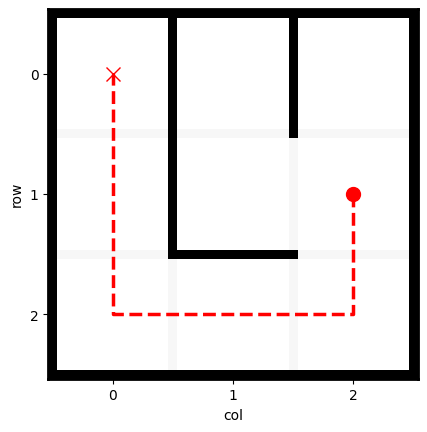

In [50]:
MazePlot(maze_dataset[0]).plot()
plt.show()

In [51]:
tokenizers: pd.DataFrame = pd.DataFrame( 
    columns=["tokenizer", "tokens", "encoding", *mt_default.summary().keys()]
    )
tokenizers.tokenizer = ALL_TOKENIZERS
tokenizers.tokens = tokenizers.tokenizer.apply(lambda x: " ".join(maze_dataset[0].as_tokens(x)))
tokenizers.encoding = tokenizers.tokens.apply(mt_default.encode)
for k in mt_default.summary().keys():
    tokenizers[k] = tokenizers.tokenizer.apply(lambda x: getattr(x, k))

tokenizers

,tokenizer,tokens,encoding,prompt_sequencer,coord_tokenizer,adj_list_tokenizer,target_tokenizer,path_tokenizer
0,MazeTokenizer2-PromptSequencers.AOTP()-CoordTo...,"<ADJLIST_START> (1,2) <--> (0,2) ; (0,0) <--> ...","[0, 1602, 8, 1600, 9, 1596, 8, 1598, 9, 1602, ...",PromptSequencers.AOTP(),CoordTokenizers.UT(),"AdjListTokenizers.Coords(intra=True, post=True...",TargetTokenizers.Unlabeled(post=False),PathTokenizers.Coords(post=False)
1,MazeTokenizer2-PromptSequencers.AOTP()-CoordTo...,"<ADJLIST_START> ( 1 , 1 ) <--> ( 0 , 1 ) ; ( 2...","[0, 11, 321, 12, 321, 13, 8, 11, 320, 12, 321,...",PromptSequencers.AOTP(),"CoordTokenizers.CTT(pre=True, intra=True, post...","AdjListTokenizers.Coords(intra=True, post=True...",TargetTokenizers.Unlabeled(post=False),PathTokenizers.Coords(post=False)
